In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint 
from lmfit import minimize, Parameters, Parameter, report_fit #download lmfit: https://lmfit.github.io/lmfit-py/installation.html

In [2]:
df_10k = pd.read_csv ('10krace.csv')
secs = df_10k['secs'].tolist()
hr = df_10k['hr'].tolist()
speed_kph = df_10k['kph'].tolist()
df_10k.head()

,secs,cad,hr,km,kph,nm,watts,alt,lon,lat,...,interval,lrbalance,lte,rte,lps,rps,smo2,thb,o2hb,hhb
0,1,0,84,0.009918,35.7061,0,0,-1.80,54.347944,24.415457,...,0,-255,0,0,0,0,0,0,0,0
1,2,86,89,0.011877,29.9750,0,0,-1.64,54.347941,24.415474,...,0,-255,0,0,0,0,0,0,0,0
2,3,86,89,0.013835,24.2439,0,0,-1.48,54.347938,24.415492,...,0,-255,0,0,0,0,0,0,0,0
3,4,86,89,0.015794,18.5128,0,0,-1.32,54.347935,24.415509,...,0,-255,0,0,0,0,0,0,0,0
4,5,86,89,0.017752,12.7817,0,0,-1.16,54.347932,24.415527,...,0,-255,0,0,0,0,0,0,0,0


Simply plotting my heart rate and speed data:

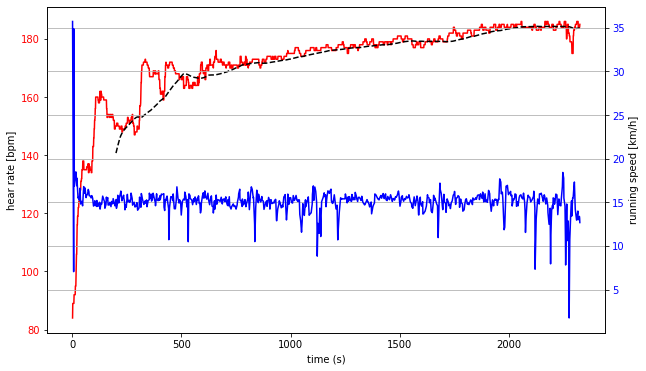

In [3]:
d = pd.Series(hr)
smooth_hr = d.rolling(200).mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1_color = 'red'
ax1.plot(secs,hr,color=ax1_color,label='heart rate')
ax1.plot(secs,smooth_hr,color="black",linestyle='--')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('hear rate [bpm]')
ax1.tick_params(axis='y', labelcolor=ax1_color)

ax2 = ax1.twinx()
ax2_color = 'blue'
ax2.plot(secs,speed_kph,color=ax2_color,label='speed [km/h]')
ax2.set_ylabel('running speed [km/h]')
ax2.tick_params(axis='y', labelcolor=ax2_color)

plt.grid()


In [4]:
def ode_model(X,t,a1,a2,a3,a4,a5):
    norm_speed = 1
    x1,x2 = X
    x1_dot = -a1*x1 + a2*(x2+norm_speed**2)
    phi = a4*x1/(1+np.exp(-(x1-a5)))
    x2_dot = -a3*x2 + phi
    return [x1_dot,x2_dot]

t = np.linspace(0,len(secs),len(secs))
X0 = [0,0]

In [5]:
def ode_solver(t, initial_conditions, params):
    x1_init, x2_init = initial_conditions
    a1, a2, a3, a4, a5 = params['a1'].value, params['a2'].value, params['a3'].value, params['a4'].value, params['a5'].value
    res = odeint(ode_model, [0,0], t, args=(a1,a2,a3,a4,a5))
    return res

def error(params, initial_conditions, tspan, data):
    sol = ode_solver(tspan, initial_conditions, params)
    return (sol[:,0] - data).ravel() #I'm only interested in minimizing x1 (x2 is essentially unknown)

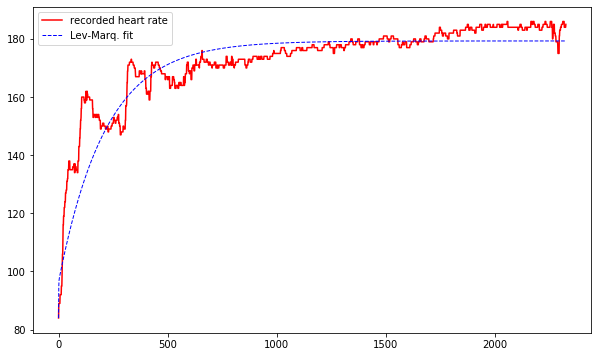

In [29]:
#initial conditions
x1_init = 0
x2_init = 0
initial_conditions = [x1_init, x2_init]
HR_rest = hr[0] #reasting heart rate, essentially the heart rate recorded at race start

#initial parameter guess:
a1 = 2
a2 = 20
a3 = 4e-2
a4 = 2e-3
a5 = 8

params = Parameters()
params.add('a1', value=a1, min=0, max=20)
params.add('a2', value=a2, min=0, max=40)
params.add('a3', value=a3, min=0, max=5)
params.add('a4', value=a4, min=0, max=5)
params.add('a5', value=a5, min=0, max=40)

tspan = np.linspace(0,len(secs),len(secs))
data = np.array(hr)-HR_rest

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')
plt.figure(figsize=(10, 6))
plt.plot(t, hr, color="red",label='recorded heart rate')
final_x1 = data + result.residual.reshape(data.shape)
plt.plot(t, np.array(final_x1)+HR_rest, '--', linewidth=1, color='blue',label="Lev-Marq. fit")
plt.legend()
